## Four Degree-of-Freedom System

### Known
- $ \left[ M \right] $ 
- $ a_0,\ a_1 $
- $ \left[ C \right] = a_0 \left[ M \right] + a_1 \left[ K \right] $
- $ K_{ij} \geq 0\ \forall (i, j) \in \mathbb{N} \times \mathbb{N} $
- $ \left[ K \right] $ is sparse
- $ \left[ K \right] = \sum_{i=1}^4 \left[ \mathbb{K}_\text{basis} \right]_i \cdot E_i $

### Unknown
- $ \mathbb{E} = \bigcup_{i=1}^4 E_i $
- $ \alpha_\pi $

### Constraints
- $ \mathcal{J}_\mathcal{D} = \frac{1}{2} \sum_{i=1,3} \left( \hat{u}_i - u_i \right)^2 $ (data loss)
- $ E_{ij} \geq 0\ \forall (i, j) \in \mathbb{N} \times \mathbb{N} $ (hard constraint)
- $ \mathcal{J}_\pi = \alpha_\pi \mathcal{L}_2\left( \left[ M \right]\left[ \ddot{u} \right] + \left[ C \right]\left[ \dot{u} \right] + \left[ K \right]\left[ u \right] - \left[ f(t) \right] \right) $
- $ \mathcal{J}_\mathcal{S} = \mathcal{L}_1\left( \left[ K \right] \right) $ (sparsity enforcement, not used here because the 4DOF K-matrix is not actually sparse)

### Definitions
$\mathcal{L}_1$: Taxicab norm\
$\mathcal{L}_2$: Euclidiean norm

In [1]:
print("Importing libraries...")
## Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import deepxde as dde
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from generate_data import get_data

print("Done.")

## Set hyperparameters
np.random.seed(123)
N_DEGREES_OF_FREEDOM = 4
N_COLLOC_POINTS = 60
device = "cuda"

Importing libraries...


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Done.


In [2]:
print("Getting training data...")
## Get training data
data_folder = "data"
required_files = [
    "C",
    "Damp_param",
    "K",
    "M",
    "Vel_3_2D",
    "Vel_4_2D",
    "t",
    "load",
    "k_basis",
    "Y",
]
if not all([os.path.isfile(f"{data_folder}/{fn}.txt") for fn in required_files]):
    get_data(data_folder=data_folder)

max_rows = 290
data = {
    name: np.loadtxt(f"{data_folder}/{name}.txt", max_rows=max_rows)
    for name in required_files
}
print("Done.")

Getting training data...
Done.


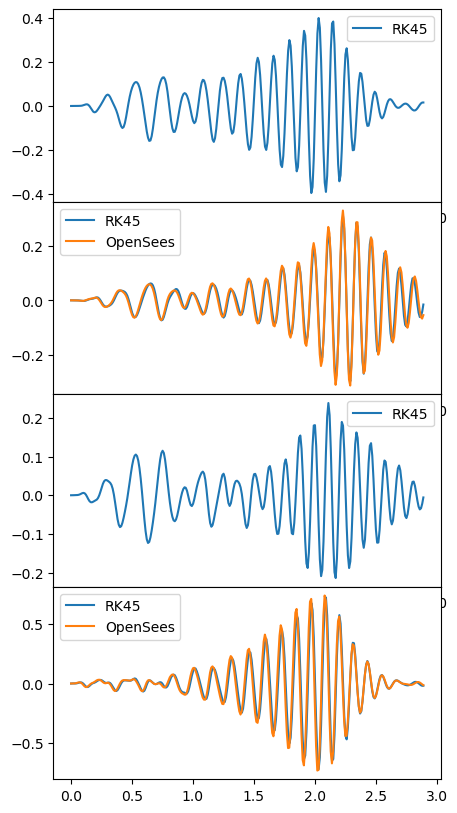

In [3]:
def force_magnitude(t):
    return np.interp(t, data["t"], data["load"]) * 1e3


force_idx = 3


def ode(t, u):
    y = u[:4].reshape(-1, 1)
    dy_dt = u[4:].reshape(-1, 1)

    force = force_magnitude(t)
    force_vec = np.zeros(4).reshape(-1, 1)
    force_vec[force_idx, 0] = -force

    # d2y_dt2 = np.linalg.inv(data["M"]) @ (force_vec - data["K"] @ y - data["C"] @ dy_dt)

    # Using k_basis
    d2y_dt2 = np.linalg.inv(data["M"]) @ (
        force_vec
        - (data["k_basis"] * data["Y"]) @ y
        - (data["Damp_param"][0] * data["M"] + data["Damp_param"][1] * data["K"])
        @ dy_dt
    )
    return np.hstack((dy_dt.squeeze(), d2y_dt2.squeeze()))


u0 = np.zeros(4 * 2)
tspan = (0, data["t"][-1])
sol = solve_ivp(ode, tspan, u0, max_step=1e-2)
tsol = sol.t
usol = sol.y[:4]
usol_derivative = sol.y[4:]

gs = gridspec.GridSpec(4, 1, height_ratios=np.ones(4), hspace=0)
fig = plt.figure(figsize=(5, 10))
for dim in range(4):
    ax = fig.add_subplot(gs[dim])
    ax.plot(tsol, usol_derivative[dim], label="RK45")

    match dim:
        case 1:
            ax.plot(data["t"], data["Vel_3_2D"], label="OpenSees")
        case 3:
            ax.plot(data["t"], data["Vel_4_2D"], label="OpenSees")
    ax.legend()

In [4]:
## Set up DeepXDE model
print("Setting up DeepXDE model...")
# Define domain
geometry = dde.geometry.TimeDomain(0, data["t"][-1])

# Define parameters
E_learned = dde.Variable(1.0)
# alpha_pi = dde.Variable(1.0)

# Define other tensors
M = torch.Tensor(data["M"])
K_basis = torch.Tensor(data["k_basis"])


# Define the ODE residual
def system(t, u):
    y = u
    y_t = torch.zeros_like(y).to(device)
    y_tt = torch.zeros_like(y).to(device)

    for dim in range(N_DEGREES_OF_FREEDOM):
        y_t[:, dim] = dde.grad.jacobian(u, t, i=dim, j=0).squeeze()
        y_tt[:, dim] = dde.grad.hessian(u, t, component=dim).squeeze()

    E = torch.abs(E_learned)
    K = K_basis * E
    C = data["Damp_param"][0] * M + data["Damp_param"][1] * K

    F = np.zeros((t.shape[0], u.shape[1]))
    f_quasiscalar = force_magnitude(t.detach().cpu()).squeeze()
    F[:, force_idx] = -f_quasiscalar
    F = torch.Tensor(F)

    residual = (
        torch.mm(M, y_tt.permute((1, 0)))
        + torch.mm(torch.abs(C), y_t.permute((1, 0)))
        + torch.mm(torch.abs(K), y.permute((1, 0)))
        - F.permute((1, 0))
    ).permute((1, 0))

    multiplier = 2  # multiply physics loss by 2. not having this as a weight anymore since the optimizer just tried to minimize it.
    return multiplier * residual


def differentiate_u(t, u, component):
    return dde.grad.jacobian(u, t, i=component, j=0).reshape(-1, 1)


# B.C.'s on the velocity
bcs = [
    # Enforce y-velocity of node 3
    dde.icbc.boundary_conditions.PointSetOperatorBC(
        data["t"].reshape(-1, 1),
        data["Vel_3_2D"].reshape(-1, 1),
        (lambda t, u, X: differentiate_u(t, u, 1)),
    ),
    # Enforce y-velocity of node 4
    dde.icbc.boundary_conditions.PointSetOperatorBC(
        data["t"].reshape(-1, 1),
        data["Vel_4_2D"].reshape(-1, 1),
        (lambda t, u, X: differentiate_u(t, u, 3)),
    ),
    # Set initial x-velocity of node 3 to 0
    dde.icbc.boundary_conditions.PointSetOperatorBC(
        np.array([[0]]), np.array([[0]]), (lambda t, u, X: differentiate_u(t, u, 0))
    ),
    # Set initial x-velocity of node 4 to 0
    dde.icbc.boundary_conditions.PointSetOperatorBC(
        np.array([[0]]), np.array([[0]]), (lambda t, u, X: differentiate_u(t, u, 2))
    ),
]

# B.C.'s on the position
bcs += [
    dde.icbc.boundary_conditions.PointSetBC(
        np.array([[0]]), np.array([[0]]), component=dim
    )
    for dim in range(N_DEGREES_OF_FREEDOM)
]

pde_data = dde.data.PDE(
    geometry=geometry, pde=system, bcs=bcs, num_domain=5000, num_boundary=2, num_test=5
)

net = dde.nn.FNN(
    layer_sizes=[1] + 30 * [50] + [N_DEGREES_OF_FREEDOM],
    activation="tanh",
    kernel_initializer="Glorot uniform",
)

model = dde.Model(pde_data, net)
model.compile("adam", lr=5e-5, external_trainable_variables=[E_learned])

variable = dde.callbacks.VariableValue(
    [E_learned], period=1000, filename="variables.dat"
)

checkpoint = dde.callbacks.ModelCheckpoint(
    "model_files/checkpoints/model", period=10_000
)

epoch = 0


def plot():
    global epoch
    epoch += 1
    if checkpoint.epochs_since_last_save + 1 < checkpoint.period:
        return
    fig = plt.figure(figsize=(5, 10))
    plt.title(
        f"Epoch: {epoch}\nE={E_learned.detach().cpu() * 1e-6: .2f} " + r"$\times 10^6$"
    )
    u_to_plot = model.predict(data["t"]).detach().cpu()
    for dim in range(4):
        ax = fig.add_suplot(gs[dim])

        ax.plot(data["t"], u_to_plot[:, dim], label="Prediction", color="black")

        # Plot Solution Data
        ax.plot(tsol, usol_derivative[dim], label="Solution (RK-45)", color="gray")

        # Plot given data
        match dim:
            case 1:
                ax.plot(
                    data["t"],
                    data["Vel_3_2D"],
                    label="True",
                    marker="x",
                    markersize=1,
                    linestyle="None",
                    color="orange",
                )
            case 3:
                ax.plot(
                    data["t"],
                    data["Vel_4_2D"],
                    label="True",
                    marker="x",
                    markersize=1,
                    linestyle="None",
                    color="orange",
                )
            case _:
                ax.plot(
                    0,
                    0,
                    label="True",
                    marker="x",
                    markersize=1,
                    linestyle="None",
                    color="orange",
                )

        ax.set_ylabel(r"$u_%s(t)$" % (dim))
        if dim != 3:
            ax.xaxis.set_ticklabels([])
        if dim == 3:
            ax.set_xlabel(r"Time ($t$)")
        ax.legend()
    plt.savefig(f"plots/training/epoch_{epoch}_prediction.png")
    plt.close()


checkpoint.on_epoch_begin = plot
print("Done.")
losshistory, train_state = model.train(
    iterations=int(2e6), callbacks=[variable, checkpoint]
)

Setting up DeepXDE model...
Compiling model...
'compile' took 0.000281 s

Done.
Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [2.65e+09, 1.05e-02, 6.33e-02, 1.41e-02, 6.35e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [4.26e+09, 1.05e-02, 6.33e-02, 1.41e-02, 6.35e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  


KeyboardInterrupt: 

In [ ]:
print("Saving model...")
model.save("model_files/model")
dde.utils.saveplot(losshistory, train_state, issave=True, isplot=True)
print("Done.")

#### Print final E vector #####
print("Final learned E vector\n", "----------")
print("E = \n", E_learned.detach())

print("True E vector\n", "----------")
print("EK = \n", data["Y"])